# Analiza eksploracyjna

Poniższy notebook postara się przeanalizować rozpatrywany zbiór danych.

In [1]:
import pandas as pd

df = pd.read_csv('data/processed/reviews.csv')

df.info()

/tmp/ipykernel_30/127158758.py:3: DtypeWarning: Columns (8,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/reviews.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094411 entries, 0 to 1094410
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   product_name_x              1094411 non-null  object 
 1   brand_name_x                1094411 non-null  object 
 2   loves_count                 1094411 non-null  int64  
 3   rating                      1094411 non-null  float64
 4   reviews                     1094411 non-null  float64
 5   size                        1051048 non-null  object 
 6   variation_type              1042956 non-null  object 
 7   variation_value             1030978 non-null  object 
 8   variation_desc              8283 non-null     object 
 9   ingredients                 1072386 non-null  object 
 10  price_usd_x                 1094411 non-null  float64
 11  value_price_usd             30877 non-null    float64
 12  sale_price_usd              9753 non-null     float64
 1

Analizowany zbiór posiada 46 kolumn, z czego duża część posiada puste wartości w zbiorze danych:

In [2]:
not_null = df.notnull().mean() * 100
print(not_null[not_null < 100].sort_values(ascending=False))

print(f'Columns not having empty values count: {not_null[not_null == 100].count()}')
print(f'Columns having empty values count: {not_null[not_null < 100].count()}')
print(f'Total columns count: {not_null.count()}')

text_len                      99.868057
review_text                   99.868057
contains_capslock             99.868057
contains_emoticon             99.868057
ingredients                   97.987502
size                          96.037777
variation_type                95.298384
variation_value               94.203914
skin_type                     89.806663
highlights                    89.589286
tertiary_category             85.265499
skin_tone                     84.417280
eye_color                     80.845587
hair_color                    79.279448
review_title                  71.614503
contains_exclamation_point    71.614503
helpfulness                   48.685457
child_max_price               41.428951
child_min_price               41.428951
value_price_usd                2.821335
sale_price_usd                 0.891164
variation_desc                 0.756845
dtype: float64
Columns not having empty values count: 24
Columns having empty values count: 22
Total columns count: 46


Blisko połowa kolumn posiada pewne puste wartości, ale większość z nich posiada 50% nie pustych wartości. Wyjątek stanowią helpfulness, child_max_price, child_min_price, value_price_usd, sale_price_usd i variation_desc. Szczególnie ostatnie 3 posiadają zdecydowaną większość rekordów pustych, więc ich użyteczność jest zdaje się znikoma. Stąd prawdopodobnie należy nie brać ich pod uwagę w trakcie budowy modelu.

Dla kolumn, w których większość wartości jest niepustych, można zdecydować się na uzupełnienie ich medianą kolumny lub uzupełnić wartością innego najbardziej podobnego wiersza, który posiada dany atrybut nie pusty.

Rozkład kolumny "LABEL-rating" prezentuje się następująco:

<Axes: xlabel='LABEL-rating'>

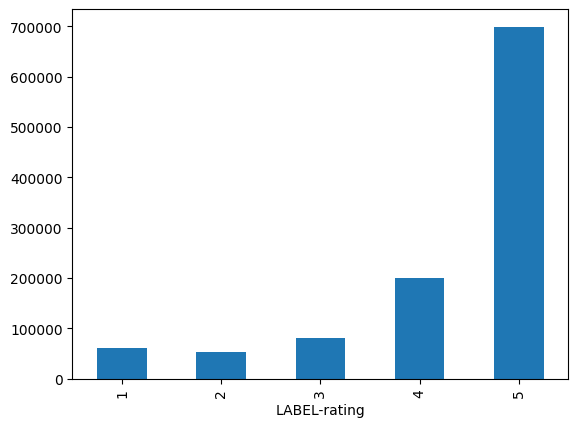

In [3]:
import matplotlib.pyplot as plt

df['LABEL-rating'].value_counts().sort_index().plot(kind='bar')


Powyższy wykres pokazuje, że w zbiorze danych mamy do czynienia z niezrównoważoną klasą. Wartości 1 i 2 są znacznie mniej reprezentowane niż wartości 3, 4 i 5. Szczególnie klasa 5 jest reprezentowana przez większość rekordów. Może to sugerować, że korzystne będzie wykorzystanie modelu, który będzie odporny na nierówną dystrybucję zbioru wynikowego.

Co więcej powyższy wykres prezentuje, że klasa wynikowa to wartość numeryczna. Spośród pozostałych kolumn liczba wartości numerycznych i kategorycznych prezentuje się następująco:

In [4]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
print(f'Numeric columns count: {len(numeric_columns)}')

categorical_columns = df.select_dtypes(include=['object']).columns
print(f'Categorical columns count: {len(categorical_columns)}')


Numeric columns count: 23
Categorical columns count: 23


Liczba wartości numerycznych jest podobna do liczby wartości kategorycznych.

Oceńmy jak dane numeryczne są powiązane ze sobą:

<Axes: >

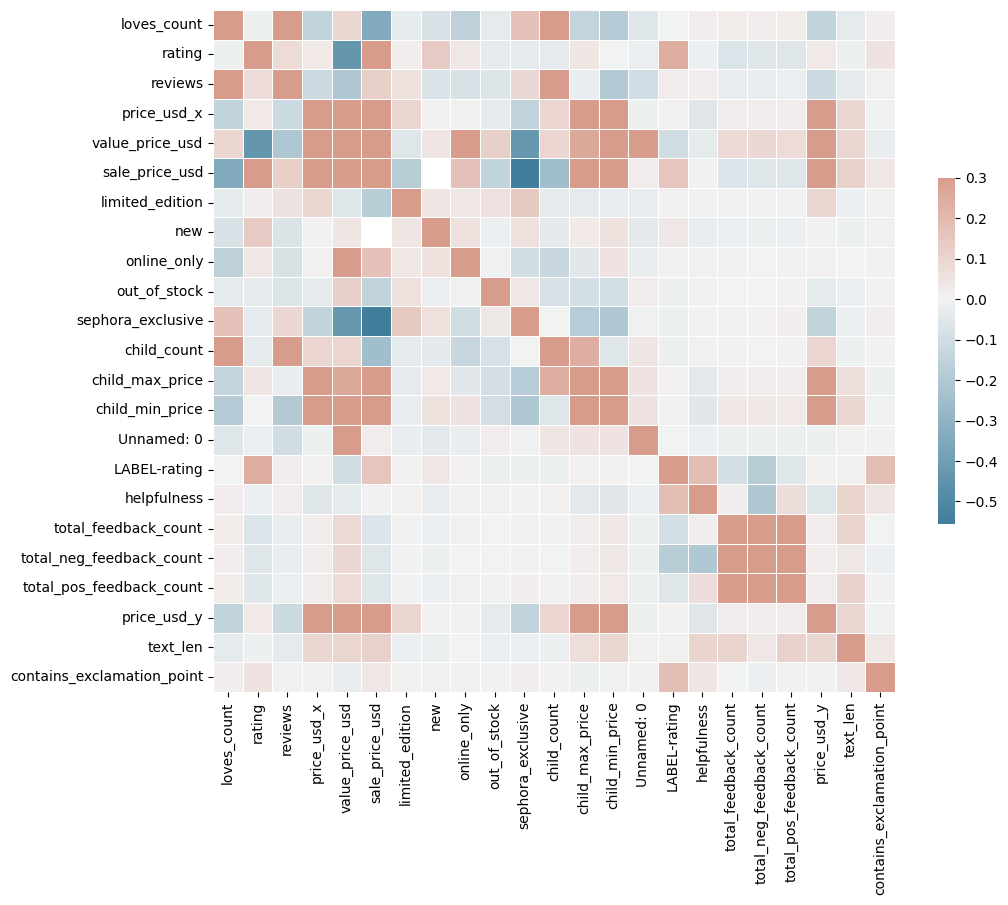

In [5]:
import seaborn as sns

corr = df.select_dtypes(include=['int64', 'float64']).corr()

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Większość cech nie jest ze sobą skorelowane, choć występują wyjątki np. powiązanie między loves_count i rating, a także sales_price_usd oraz rating.
Występuje wiele niepowiązanych atrybutów co może sugerować, że warto będzie zweryfikować użyteczność modelu Naive Bayess.

Klasa docelowa koreluje z atrybutami 'rating' (średnią ocen danego produktu), sales_price_usd (choć tu należy mieć na uwadzę, małą liczbę rekordów), helpfulness, total_feedback_count, neg_total_feedback_count, pos_total_feedback_count a także contains_exclamation_point. Co można zobaczyć dokładniej poniżej:

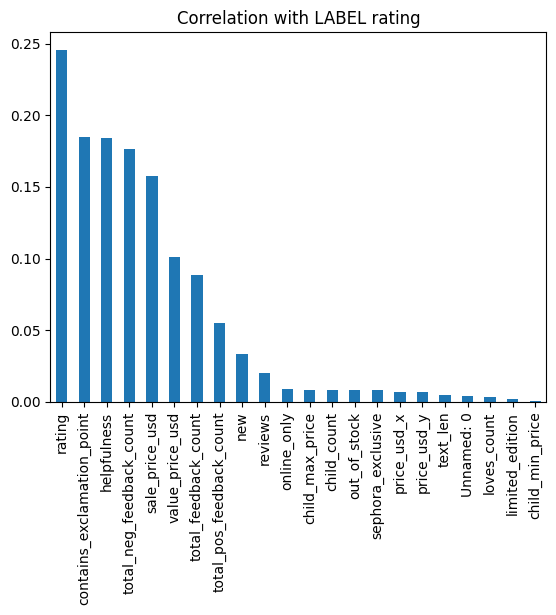

In [6]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()['LABEL-rating'].drop(labels='LABEL-rating').apply(abs).sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with LABEL rating')
plt.show()


Żadna cecha nie przewyższa wartości korelacji 0.25, ale jest kilka cech, które sugerują że możliwe będzie na ich podstawie wyznaczenie klasy LABEL-rating. Najmniej korelacji wykazują child_min_price oraz limited_edition.

Przeanalizujmy dane tekstowe - zacznijmy od wykrycia najbardziej powtarzalnych słów:

[nltk_data] Downloading package stopwords to /app/data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total words count: 194272


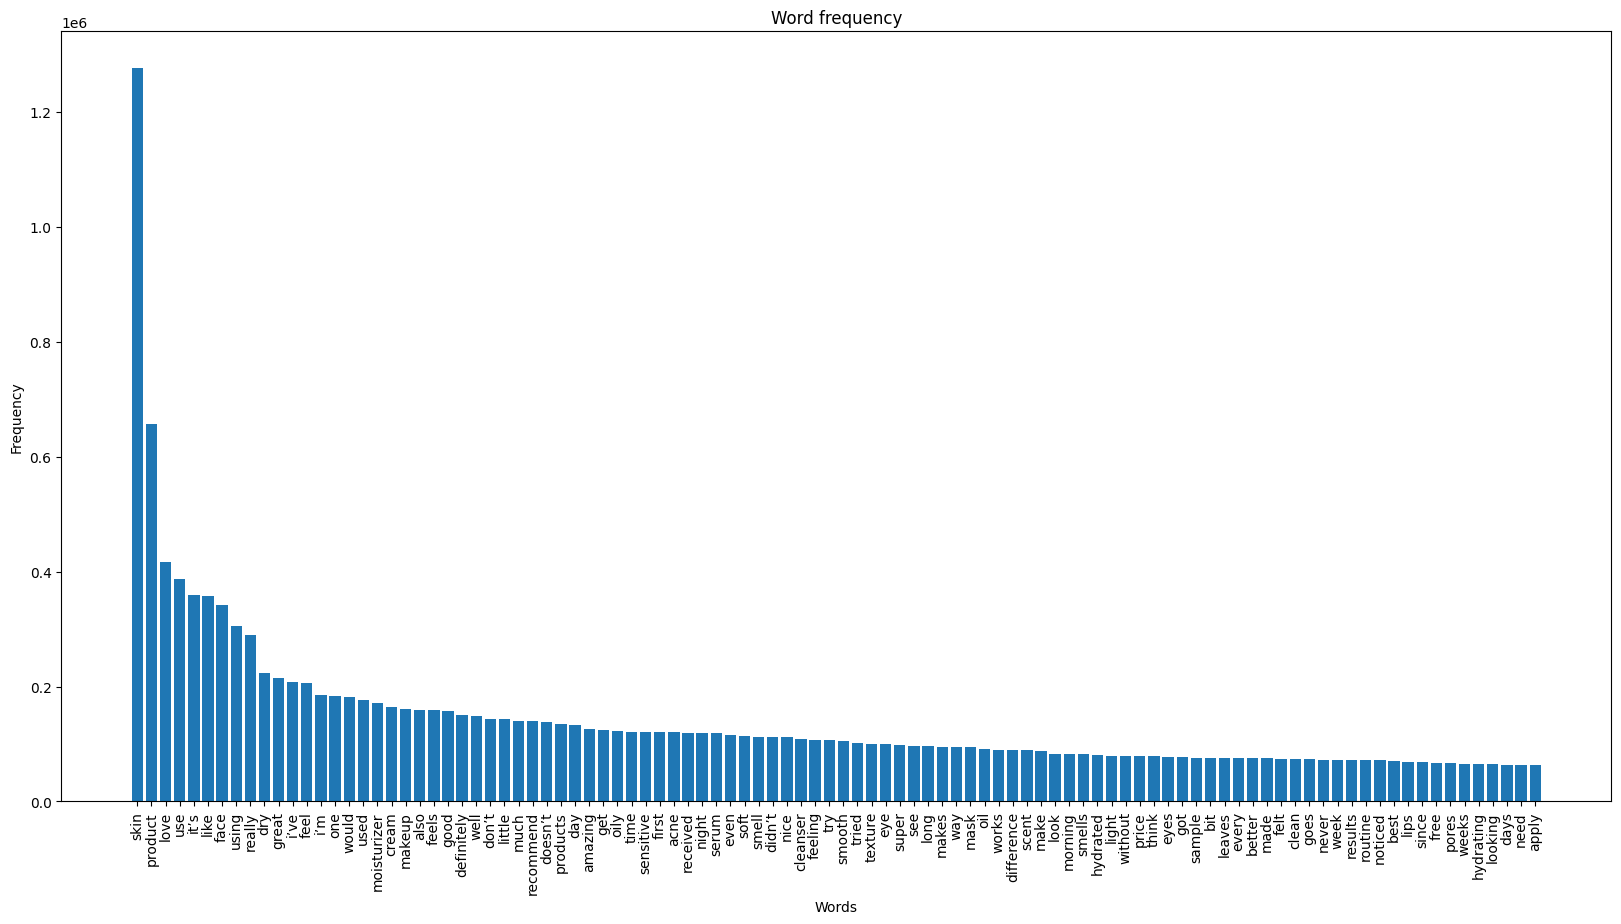

In [7]:
import nltk
import os
from nltk.tokenize import word_tokenize
import heapq
import re
import nltk
from nltk.corpus import stopwords

download_dir = "/app/data/nltk_data"
nltk.data.path.append(download_dir)
nltk.download(info_or_id='stopwords', download_dir=download_dir)

all_text = " ".join(df["review_text"].astype(str)).lower()
all_text = re.sub(r'[\n\r\t.,!?;:"\']', ' ', all_text)
stopwords = set(stopwords.words('english'))
all_text = " ".join([word for word in all_text.split() if word not in stopwords])

word_counter = {}
for word in all_text.split():
    word_counter[word] = word_counter.get(word, 0) + 1
    
print(f'Total words count: {len(word_counter)}')

n = 100
largest_n = heapq.nlargest(n, word_counter, key=word_counter.get)  
largest_values = {key: word_counter[key] for key in largest_n}  

plt.figure(figsize=(20, 10))
word_counter = dict(sorted(largest_values.items(), key=lambda item: item[1], reverse=True))
plt.bar(word_counter.keys(), word_counter.values())
plt.xticks(rotation=90)
plt.title('Word frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Jeśli zignorujemy tzw. stop words jak np. 'and', 'the' to otrzymamy że słowa 'skin', 'product', 'love' - o ile te dwa pierwsze słowa dotyczą bardziej opisy produktu to już występowanie 'love' czy 'great' sugeruje że raczej ocena jest pozytywna. Być może warto wyliczyć wszystkie takie słowa i umieścić, jako nową kolumne.

Rozpatrzmy jak poszczególne słowa rozpatrują się w danej klasie:

/tmp/ipykernel_30/4223701445.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(word_counter.keys(), rotation=90)


/tmp/ipykernel_30/4223701445.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(word_counter.keys(), rotation=90)


/tmp/ipykernel_30/4223701445.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(word_counter.keys(), rotation=90)


/tmp/ipykernel_30/4223701445.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(word_counter.keys(), rotation=90)


/tmp/ipykernel_30/4223701445.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(word_counter.keys(), rotation=90)


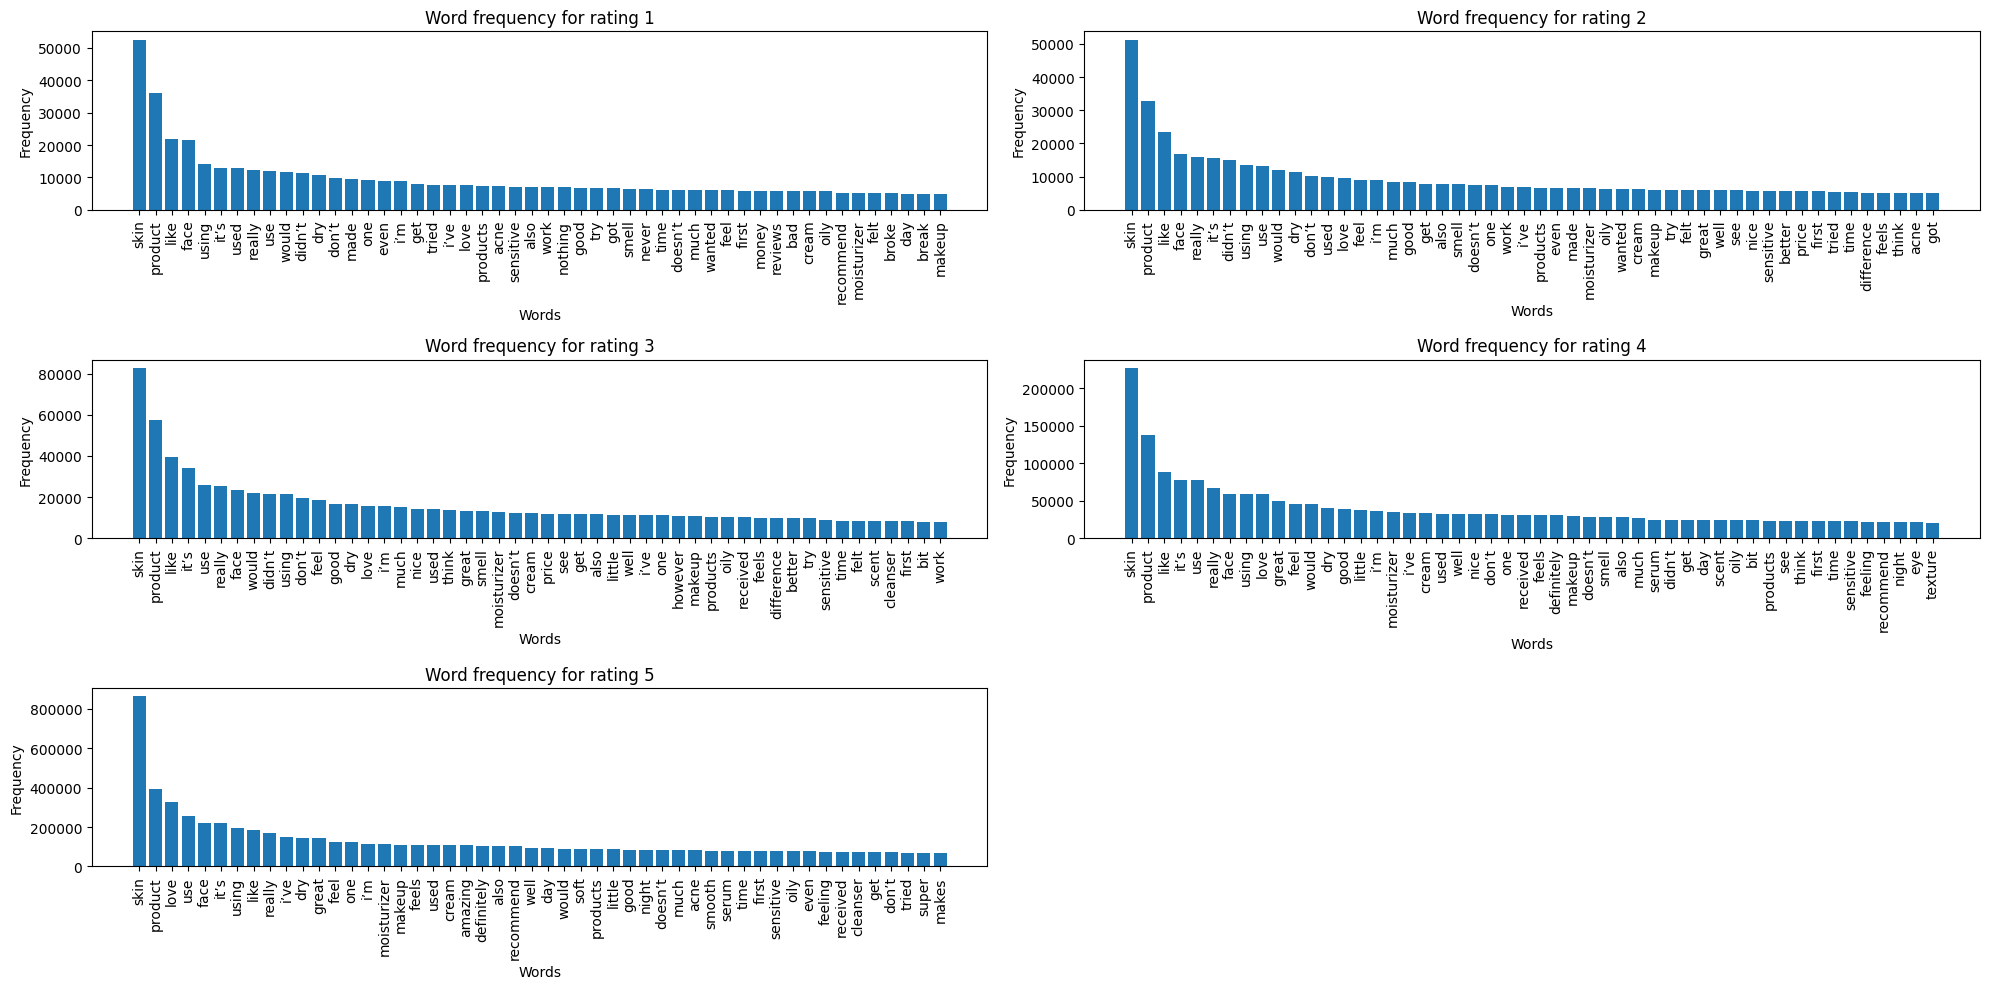

1: 1673469
2: 1619222
3: 2673873
4: 6589959
5: 21616895


In [8]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

rating_values = sorted(list(df['LABEL-rating'].value_counts().index))
text_analysis = {
    'LABEL-rating': rating_values,
    'Word count': []
}

def get_n_common_words(n, rating):
    all_text = " ".join(df[df['LABEL-rating'] == rating]["review_text"].astype(str)).lower()
    all_text = re.sub(r'[\n\r\t.,!?;:"\']', ' ', all_text)
    all_text = " ".join([word for word in all_text.split() if word not in stopwords])

    text_analysis['Word count'].append(len(all_text.split()))

    word_counter_for_class = {}
    for word in all_text.split():
        word_counter_for_class[word] = word_counter_for_class.get(word, 0) + 1

    largest_n = heapq.nlargest(n, word_counter_for_class, key=word_counter_for_class.get)
    return {key: word_counter_for_class[key] for key in largest_n}

num_ratings = len(rating_values)
cols = 2  
rows = (num_ratings // cols) + (num_ratings % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten() 

for i, value in enumerate(rating_values):
    word_counter = get_n_common_words(50, value)
    word_counter = dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))

    ax = axes[i]
    ax.bar(word_counter.keys(), word_counter.values())
    ax.set_xticklabels(word_counter.keys(), rotation=90)
    ax.set_title(f'Word frequency for rating {value}')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

for rating, count in zip(text_analysis['LABEL-rating'], text_analysis['Word count']):
    print(f'{rating}: {count}')

Powyższe wykresy prezentują że w przypadku klas 1, 2, i 3 nie występują m.in. słowa 'love', 'great'. W przypadku klasy 1 występują słowa takie, jak 'break', 'broke', sugerujące że produkt może być wadliwy.

W przypadku liczności słów rozkłada się podobnie do liczby rekordów powiazaną z daną klasą. Rozpatrzmy to względem liczby rekordów:

In [9]:
for rating, count in zip(text_analysis['LABEL-rating'], text_analysis['Word count']):
    records_of_rating = df[df['LABEL-rating'] == rating].shape[0]
    print(f'Rating {rating}: {count//records_of_rating} words for record')

Rating 1: 27 words for record
Rating 2: 30 words for record
Rating 3: 32 words for record


Rating 4: 33 words for record


Rating 5: 30 words for record


Widzimy że liczba słów na rekord jest bardzo podobna dla każdej klasy stąd nie można rozpatrywać długości jako atrybutu mogącego pomóc rozpoznać ocene.

W przypadku pozostałych miar dotyczących tekstu:

Rating 1: 0.19228775113415425 exclamation_point mean
Rating 2: 0.08319518477900482 exclamation_point mean


Rating 3: 0.07069125080088275 exclamation_point mean


Rating 4: 0.27300485451903156 exclamation_point mean


Rating 5: 0.5095356793171916 exclamation_point mean


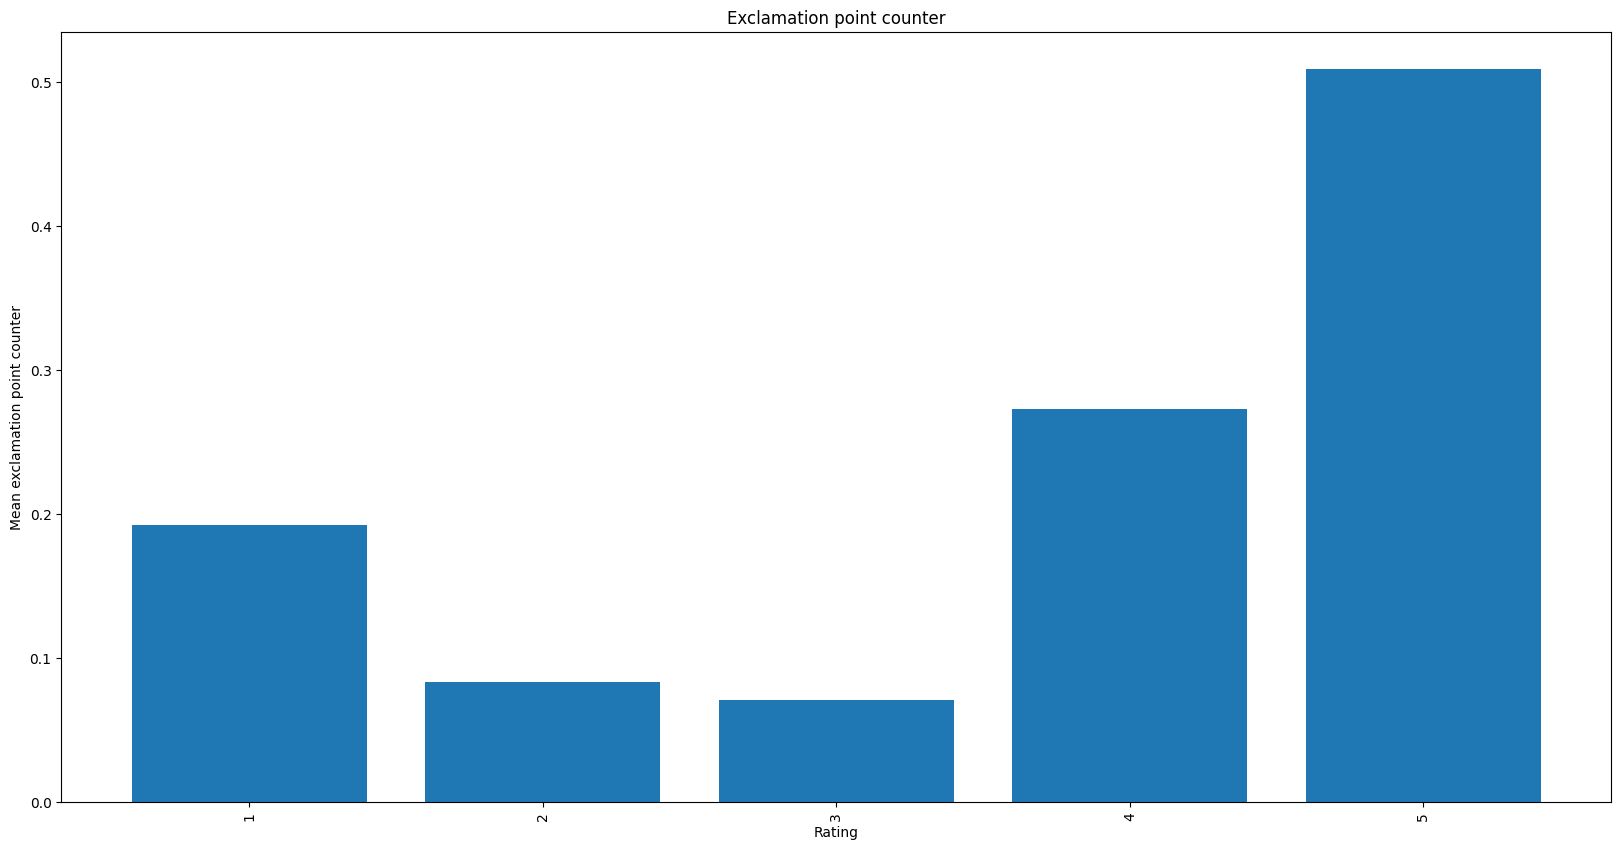

In [10]:
import numpy as np

text_analysis["exclamation_point_counter"] = []
for rating in text_analysis['LABEL-rating']:
    text_analysis["exclamation_point_counter"].append(df[df['LABEL-rating'] == rating]['contains_exclamation_point'].mean())
    records_of_rating = df[df['LABEL-rating'] == rating].shape[0]
    print(f'Rating {rating}: {text_analysis["exclamation_point_counter"][-1]} exclamation_point mean')
    
plt.figure(figsize=(20, 10))
plt.bar(text_analysis['LABEL-rating'], text_analysis["exclamation_point_counter"])
plt.xticks(rotation=90)
plt.title('Exclamation point counter')
plt.xlabel('Rating')
plt.ylabel('Mean exclamation point counter')
plt.show()

Średnie występowanie wykrzyknika sugeruje że opinia jest skrajna - albo bardzo negatywna albo pozytywna

Podobnie wygląda to w drugiej dodanej kolumnie:

Rating 1: 0.17991981016283445 contains_capslock mean
Rating 2: 0.15526097137246014 contains_capslock mean
Rating 3: 0.13961737939132987 contains_capslock mean


Rating 4: 0.1328741886743202 contains_capslock mean


Rating 5: 0.18532458954384526 contains_capslock mean


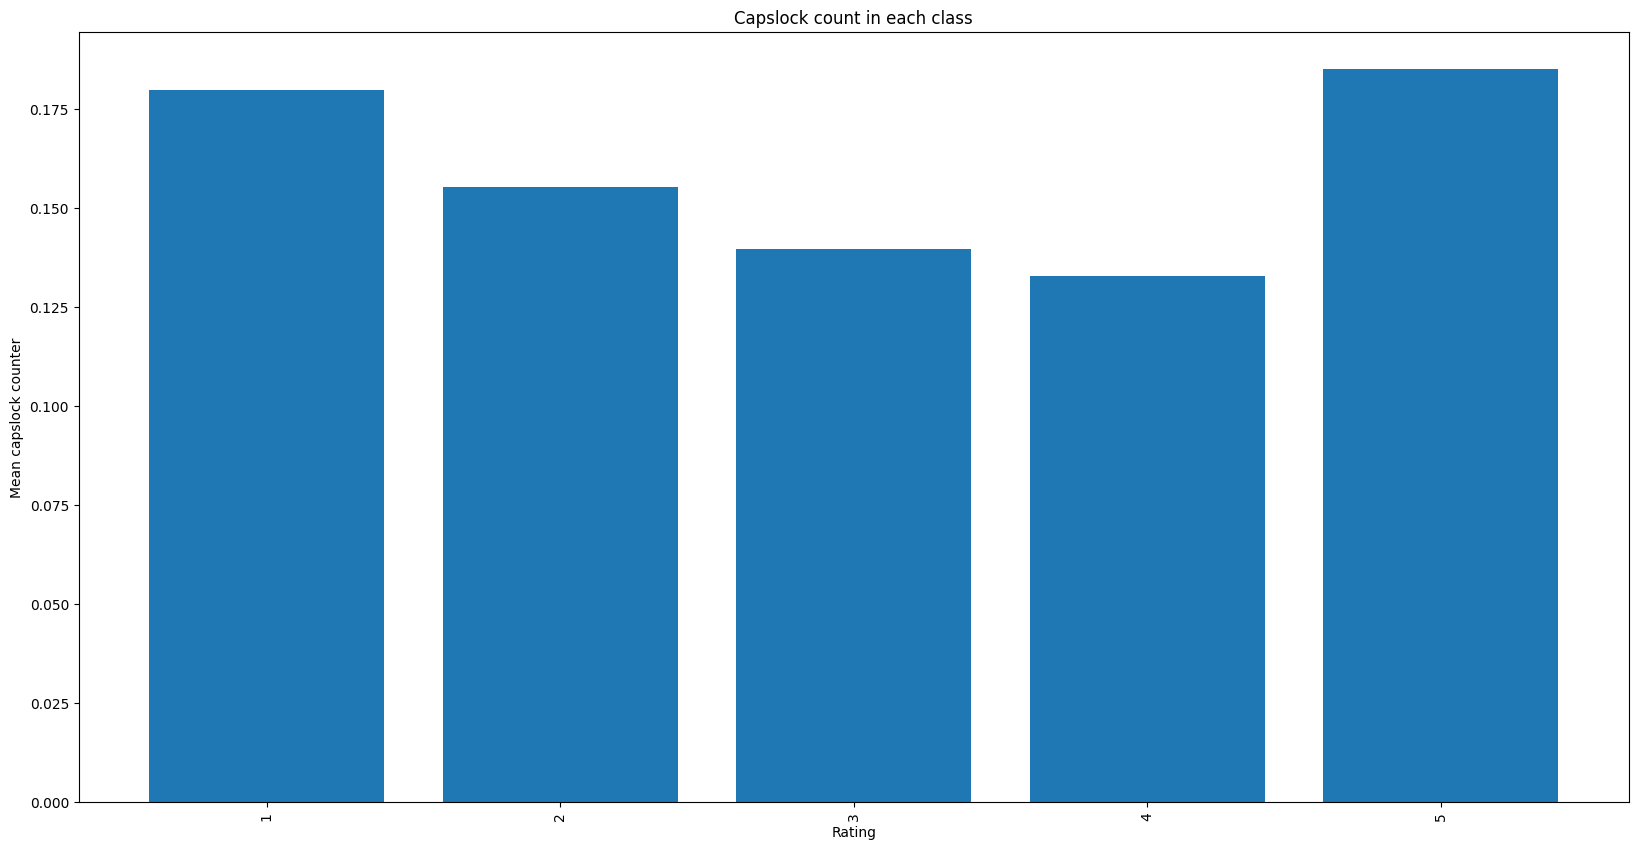

In [11]:
text_analysis["contains_capslock"] = []
for rating in text_analysis['LABEL-rating']:
    text_analysis["contains_capslock"].append(df[df['LABEL-rating'] == rating]['contains_capslock'].mean())
    records_of_rating = df[df['LABEL-rating'] == rating].shape[0]
    print(f'Rating {rating}: {text_analysis["contains_capslock"][-1]} contains_capslock mean')
    
plt.figure(figsize=(20, 10))
plt.bar(text_analysis['LABEL-rating'], text_analysis["contains_capslock"])
plt.xticks(rotation=90)
plt.title('Capslock count in each class')
plt.xlabel('Rating')
plt.ylabel('Mean capslock counter')
plt.show()

Tutaj różnice są mniej widoczne ale podobnie najczęściej pisanie słów dużymi literami występuje w skrajnych opiniach.